In [102]:
import numpy as np
import xarray as xr
from scipy.spatial import cKDTree
import dask.array as da
from dask.distributed import Client, LocalCluster
import gc
import sys
from matplotlib import pyplot as plt

In [103]:
EARTH_RADIUS_KM = 6371.0
MAX_DIST_KM = 500
TIME_TOL_HOURS = 2
ALT_MIN, ALT_MAX = 14.5, 49.5  # Updated range
ALT_GRID = np.arange(ALT_MIN, ALT_MAX + 1, dtype=np.float32)
CHORDAL_DIST = 2 * np.sin(MAX_DIST_KM / (2 * EARTH_RADIUS_KM))
TIME_TOL = np.timedelta64(TIME_TOL_HOURS, 'h').astype('timedelta64[ns]')

# Optimized chunk sizes
CHUNK_SIZE_L = 50000
CHUNK_SIZE_S = 25000
CHUNK_SIZE_S_PROCESS = 2000
BATCH_SIZE = 10000

In [104]:
def wrap_o3_efficient(da_o3):
    """Efficient wrapping with optimized chunking"""
    da_transposed = da_o3
    
    time_chunks = CHUNK_SIZE_L if da_transposed["time"].size > 500000 else CHUNK_SIZE_S
    
    if isinstance(da_transposed.data, da.Array):
        ozone_data = da_transposed.data.rechunk((time_chunks,))
    else:
        ozone_data = da.from_array(da_transposed.data, chunks=((time_chunks,)))
    
    return xr.Dataset(
        {'ozone': (('time'), ozone_data)},
        coords={
            'time': da_transposed.time,
            'latitude': ('time', da_transposed.latitude.data),
            'longitude': ('time', da_transposed.longitude.data),
        }
    )

def latlon_to_cartesian_vectorized(lat, lon):
    """Vectorized cartesian conversion with float32"""
    lat_rad = np.deg2rad(lat.astype(np.float32))
    lon_rad = np.deg2rad(lon.astype(np.float32))
    cos_lat = np.cos(lat_rad)
    
    return np.column_stack([
        cos_lat * np.cos(lon_rad),
        cos_lat * np.sin(lon_rad),
        np.sin(lat_rad)
    ]).astype(np.float32)

def compute_diffs(o3L, o3S):
    """Vectorized relative, absolute and raw difference computation"""
    sum_vals = o3L + o3S
    diff_vals = o3L - o3S
    return 200 * (diff_vals / sum_vals), np.abs(diff_vals), diff_vals

In [105]:
sys.path.extend([
    r"C:\Users\salla\Onedrive(uoft acc)\OneDrive - University of Toronto\Desktop\School Information\NSERC\OSIRIS",
    r"C:\Users\salla\Onedrive(uoft acc)\OneDrive - University of Toronto\Desktop\School Information\NSERC\ACEFTS"
])

import OSIRIS_helper as OSIRIS
import ACEFTS_helper as ACE

In [106]:
daL = OSIRIS.get_column_DU(ALT_MIN, ALT_MAX)
daS = ACE.get_column_DU(ALT_MIN, ALT_MAX)

dsL = wrap_o3_efficient(daL)
dsS = wrap_o3_efficient(daS)

In [107]:
cluster = LocalCluster(
    n_workers=2,
    threads_per_worker=2,
    memory_limit='3GB',
    processes=False,
    dashboard_address=None
)
client = Client(cluster)


C:\Users\salla\AppData\Roaming\Python\Python312\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 53765 instead
  warnings.warn(


Task exception was never retrieved
future: <Task finished name='Task-1023227' coro=<Client._gather.<locals>.wait() done, defined at C:\Users\salla\AppData\Roaming\Python\Python312\site-packages\distributed\client.py:2377> exception=AllExit()>
Traceback (most recent call last):
  File "C:\Users\salla\AppData\Roaming\Python\Python312\site-packages\distributed\client.py", line 2386, in wait
    raise AllExit()
distributed.client.AllExit


In [ ]:
o3L_arr = daL.values.astype(np.float32)
o3S_arr = daS.values.astype(np.float32)

In [ ]:
tL = dsL.time.values.astype('datetime64[ns]')
tS = dsS.time.values.astype('datetime64[ns]')
latL = dsL.latitude.values
lonL = dsL.longitude.values
latS = dsS.latitude.values
lonS = dsS.longitude.values

# Pre-filter L points by time
print("Pre-filtering OSIRIS points by time...")
tS_min = tS.min() - TIME_TOL
tS_max = tS.max() + TIME_TOL
time_mask = (tL >= tS_min) & (tL <= tS_max)
tL_filtered = tL[time_mask]
o3L_arr_filtered = o3L_arr[time_mask]
latL_filtered = latL[time_mask]
lonL_filtered = lonL[time_mask]
# Cleanup memory
del dsL, dsS, o3L_arr, latL, lonL
gc.collect()

NameError: name 'dsL' is not defined

In [ ]:
xyzL = latlon_to_cartesian_vectorized(latL_filtered, lonL_filtered)
xyzS = latlon_to_cartesian_vectorized(latS, lonS)

treeL = cKDTree(xyzL, leafsize=100)

# Cleanup position arrays
del latL_filtered, lonL_filtered, latS, lonS
gc.collect()

250

In [ ]:
print("Finding spatio-temporal pairs and computing differences...")
nS = len(xyzS)
processed_pairs = 0
coincedences = []
n_alt = len(ALT_GRID)

stats = {
    'rel': [],
    'abs': [],
    'raw': []
}

for start_idx in range(0, nS, CHUNK_SIZE_S_PROCESS):
    end_idx = min(start_idx + CHUNK_SIZE_S_PROCESS, nS)
    xyzS_chunk = xyzS[start_idx:end_idx]
    tS_chunk = tS[start_idx:end_idx]
    o3S_chunk = o3S_arr[start_idx:end_idx]
    
    # Query spatial neighbors
    neighbors = treeL.query_ball_point(
        xyzS_chunk, 
        r=CHORDAL_DIST,
        workers=1,
        return_sorted=True
    )
    
    # Pre-allocate arrays for batch processing
    all_L_indices = []
    all_S_indices = []
    
    
        # Collect valid pairs
    for j, nbrs in enumerate(neighbors):
        if not nbrs:
            continue
            
        s_idx_global = start_idx + j
        time_diffs = np.abs(tL_filtered[nbrs] - tS_chunk[j])
        time_mask = time_diffs <= TIME_TOL
        valid_nbrs = np.array(nbrs)[time_mask]
        # finding the closest in time, then also do one for distance
        # if valid_nbrs.size != 0:
        #     valid_time_diffs = valid_nbrs[np.argmin(time_diffs[time_mask])]
        #     all_L_indices.append(valid_time_diffs)
        #     all_S_indices.append(j)
        # finding the closest in time, then also do one for distance

        if valid_nbrs.size != 0:
            s_point = xyzS[s_idx_global]
            
            deltas = xyzL[valid_nbrs] - s_point
            dist_sq = np.sum(deltas**2, axis=1)

            best_idx = np.argmin(dist_sq)
            best_L_index = valid_nbrs[best_idx]
            
            all_L_indices.append(best_L_index)
            all_S_indices.append(j)

            coincedences.append((o3S_chunk[j], o3L_arr[best_L_index]))
    # Process valid pairs in batch
    if all_L_indices:
        all_L_indices = np.array(all_L_indices)
        all_S_indices = np.array(all_S_indices)
        
        # Get ozone data in bulk
        o3L_vals = o3L_arr_filtered[all_L_indices]
        o3S_vals = o3S_chunk[all_S_indices]
        
        # Compute various statistics
        rel_diffs, abs_diffs, raw_diffs = compute_diffs(o3L_vals, o3S_vals)
        
        for dtype, diff_array in zip(['rel', 'abs', 'raw'], 
                                    [rel_diffs, abs_diffs, raw_diffs]):
            valid_mask = ~np.isnan(diff_array)
                
            if np.any(valid_mask):
                valid_diffs = diff_array[valid_mask]                
                stats[dtype].extend(valid_diffs)
    
    # Progress reporting
    processed_pairs += len(all_L_indices) if len(all_L_indices) > 0 else 0
    if start_idx % (CHUNK_SIZE_S_PROCESS * 10) == 0:
        print(f"Processed {end_idx}/{nS} ACE-FTS points, {processed_pairs} pairs...")
        gc.collect()

Finding spatio-temporal pairs and computing differences...


NameError: name 'o3L_arr' is not defined

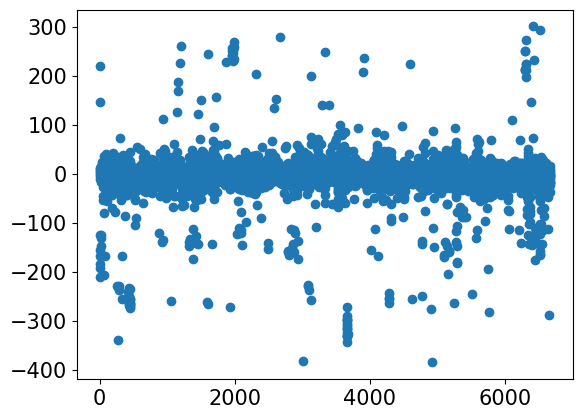

In [ ]:
plt.scatter(range(len(stats["raw"])), stats["raw"])

In [ ]:
print("Cleaning up resources...")
try:
    client.close()
    cluster.close()
    print("Dask cluster closed successfully!")
except:
    print("Note: Dask cluster may have already been closed")

gc.collect()
print("Memory cleanup completed!")

Cleaning up resources...
Dask cluster closed successfully!
Memory cleanup completed!
